# Tema : Fundamentos de Regresión y Modelos Estacionarios
![](src/img/logo_utb.png){width=40%} 
![](src/img/logo_etd.png){width=40%}
- **Profesor:**
- **Fernando Salcedo Mejía, Eco Msc.**
- Programa de Ciencias de Datos | Escuela de transformación digital.
- 2026-1

## Ejemplo 2 : El modelo macroeconómico del crecimiento del consumo en Estados Unidos

- Queremos modelar cómo cambia el consumo real (compra de bienes y servicios) de una economía según variables macroeconómicas importantes. El consumo es uno de los componentes más importantes de una economía.

$$
\Delta C_t = \beta_0 + \beta_1 Ingreso_t + \beta_2 Industria_t + \beta_3 Ahorro_t + \beta_4 Desempleo_t + \varepsilon_t
$$

- $\Delta C_t$ es el cambio porcentual en el gasto real de consumo personal.
- $Ingreso_t$​ es el cambio porcentual en el ingreso personal real disponible.
- $Industria_t$​ es el cambio porcentual en la producción industrial.
- $Ahorro_t$​ es el cambio porcentual en el ahorro personal.
- $Desempleo_t$​ es el cambio en la tasa de desempleo.

- Usar el archivo `US_change.csv` para modelar.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

from itertools import combinations
from functools import partial
from typing import Optional

from mlforecast import MLForecast
from mlforecast.target_transforms import GlobalSklearnTransformer
from mlforecast.utils import PredictionIntervals
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from utilsforecast.feature_engineering import fourier, pipeline, trend
from cycler import cycler
import matplotlib as mpl

from fpppy.models import LinearRegression

mpl.rcParams['axes.prop_cycle'] = cycler(color=["#569CC6", "#D55F03", "#13A076"])

def plot_diagnostics(
    forecaster,
    model: Optional[str] = None,
    n_lags: int = None,
    target_col: str = "y",
    time_col: str = "ds",
):
    # Plot first model only if no model spec is given
    if model is None:
        model = list(forecaster.models.keys())[0]
    fitted = forecaster.forecast_fitted_values().assign(
        resid=lambda x: x[target_col] - x[model]
    )

    _, axes = plt.subplot_mosaic([["resid", "resid"], ["acf", "hist"]])

    ax = axes["resid"]
    ax.plot(fitted[time_col], fitted["resid"], marker='.')
    ax.set(title="Innovation Residuals")

    ax = axes["acf"]
    plot_acf(
        fitted["resid"], ax=ax, zero=False, lags=n_lags,
        bartlett_confint=False, auto_ylims=True)
    ax.set(title="ACF Plot", xlabel="lag[1]", ylabel='acf')

    ax = axes["hist"]
    ax.hist(fitted["resid"], bins=20)
    ax.set(title="Histogram", xlabel="resid", ylabel="count")

def adj_r2_score(y, y_hat, T, k):
    r2 = r2_score(y, y_hat)
    return 1 - (1 - r2) * (T - 1) / (T - k - 1)

def aic_score(y, y_hat, T, k):
    sse = np.sum((y - y_hat) ** 2)
    return T * np.log(sse / T) + 2 * (k + 2)

def aicc_score(y, y_hat, T, k):
    aic = aic_score(y, y_hat, T, k)
    return aic + (2 * (k + 2) * (k + 3)) / (T - k - 3)

def bic_score(y, y_hat, T, k):
    sse = np.sum((y - y_hat) ** 2)
    return T * np.log(sse / T) + (k + 2) * np.log(T)

def cv_score(mf, model='LinearRegression'):
    fitted_model = mf.models_[model]
    X = fitted_model._X_design  
    y = fitted_model._y
    e = fitted_model._residuals
    XtX_inv = np.linalg.pinv(X.T @ X)
    h = np.sum((X @ XtX_inv) * X, axis=1) 
    return np.nanmean((e / (1 - h))**2)

def print_regression_summary_from_model(model):
    X = model._X.values.astype(float)
    y = model._y
    resid = model._residuals

    n, p = X.shape
    X_design = np.hstack([np.ones((n, 1)), X])
    dof = n - p - 1

    # residuals summary
    percentiles = [0, 25, 50, 75, 100]
    labels = ["Min", "1Q", "Median", "3Q", "Max"]
    percentiles_resid = np.percentile(resid, percentiles)
    resid_summary = pd.DataFrame({
        label: [percentile]
        for (label, percentile) in zip(labels, percentiles_resid)
    }, index=[""])

    # coefficients summary
    coef = np.insert(model.coef_, 0, model.intercept_)
    rss = np.sum(resid**2)
    mse = rss / dof
    var_beta = mse * np.linalg.inv(X_design.T @ X_design).diagonal()
    se_beta = np.sqrt(var_beta)
    t_stats = coef / se_beta
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), dof))
    names = ["(Intercept)"] + model._var_names
    stars_lookup = ["***", "**", "*", "."]
    stars_conds = [
        p_values < 0.001, p_values < 0.01,
        p_values < 0.05, p_values < 0.1]
    stars = np.select(stars_conds, stars_lookup, default="")
    coef_summary = pd.DataFrame({
        "Estimate": coef, "Std. Error": se_beta, 
        "t value": t_stats, "Pr(>|t|)": p_values, "": stars
    }, index=names)

    # more statistics
    r_squared = model.score(X, y)
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / dof
    f_stat = (r_squared / p) / ((1 - r_squared) / dof)
    f_pval = 1 - stats.f.cdf(f_stat, p, dof)

    # print the report
    print(f"Residuals:\n{resid_summary}\n\nCoefficients:\n{coef_summary}")
    print(f"---")
    signif_code_str = "0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1"
    print(f"Signif. codes: {signif_code_str}\n")

    print(
        f"Residual standard error: {np.sqrt(mse):.3f}",
        f"on {dof} degrees of freedom",
        f"\nMultiple R-squared: {r_squared:.3f},   ",
        f"Adjusted R-squared: {adj_r_squared:.3f}",
        f"\nF-statistic: {f_stat:.1f} on {p}",
        f"and {dof} DF, p-value: {f_pval:.3g}")

print_regression_summary_from_model(mf.models_["LinearRegression"])


Residuals:
       Min        1Q    Median        3Q       Max
 -2.582358 -0.277767  0.018621  0.323295  1.422291

Coefficients:
             Estimate  Std. Error   t value      Pr(>|t|)     
(Intercept)  0.544542    0.054028  10.07881  0.000000e+00  ***
Income       0.271833    0.046729   5.81728  2.402170e-08  ***
---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.591 on 196 degrees of freedom 
Multiple R-squared: 0.147,    Adjusted R-squared: 0.143 
F-statistic: 33.8 on 1 and 196 DF, p-value: 2.4e-08


c:\Users\fsalcedo\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


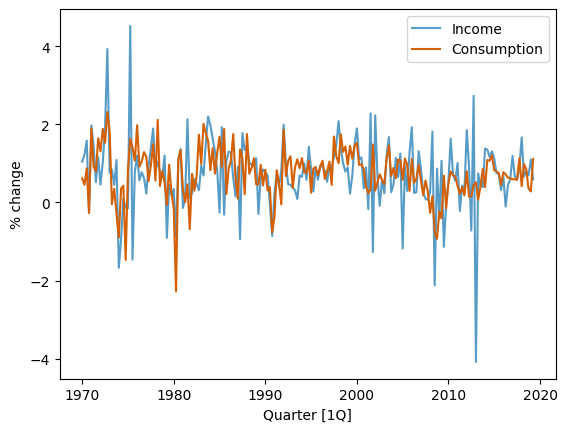

In [14]:
us_change = pd.read_csv("datos/US_change.csv", parse_dates=["ds"])

fig, ax = plt.subplots()
ax.plot(us_change["ds"], us_change["Income"], label="Income")
ax.plot(us_change["ds"], us_change["y"], label="Consumption")
ax.set(xlabel="Quarter [1Q]", ylabel="% change")
ax.legend()
plt.show()

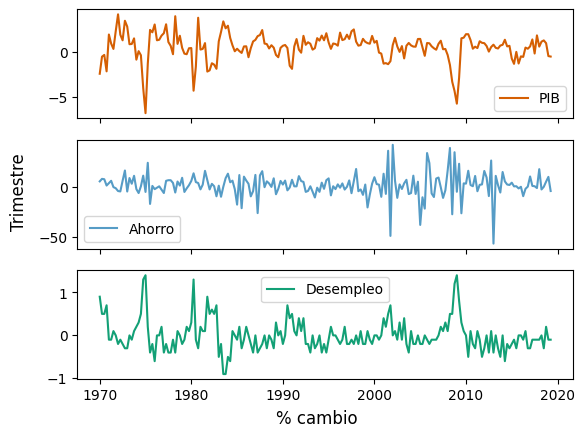

In [15]:
import seaborn as sns

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
sns.lineplot(data=us_change, x="ds", y="Production", ax=axes[0],
    color="#D55F03", label="PIB")
sns.lineplot(data=us_change, x="ds", y="Savings", ax=axes[1],
    color="#569CC6", label="Ahorro")
sns.lineplot(data=us_change, x="ds", y="Unemployment", ax=axes[2],
    color="#13A076", label="Desempleo")
for ax in axes:
    ax.set(xlabel="", ylabel="")
fig.supxlabel("% cambio")
fig.supylabel("Trimestre")
plt.show()

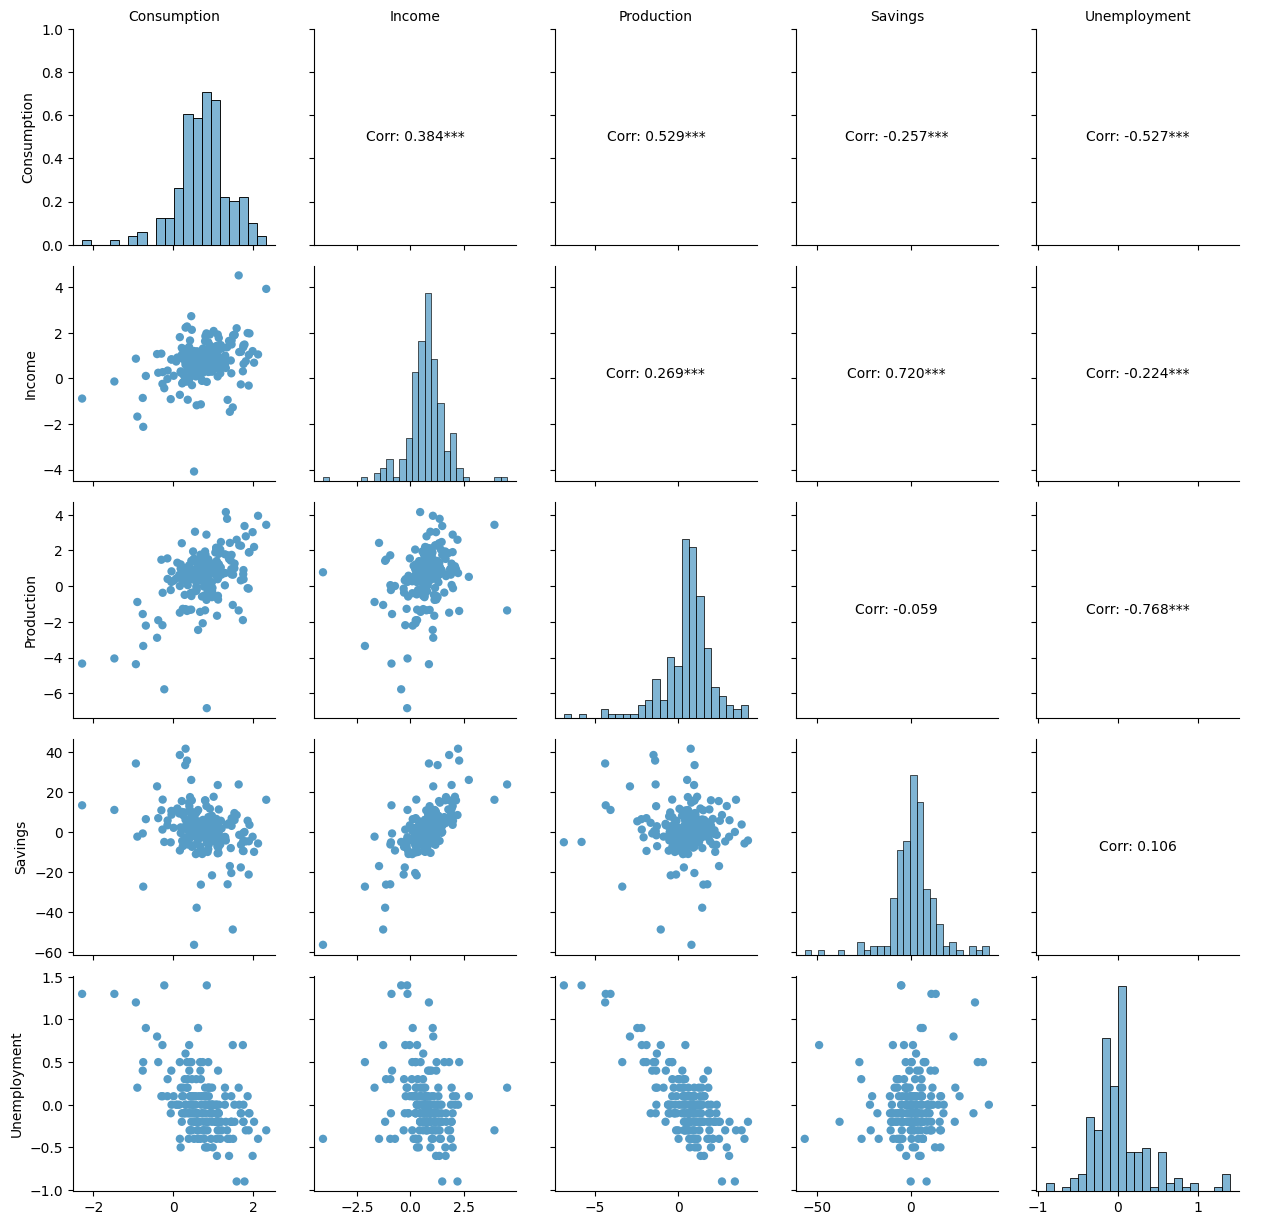

In [16]:
columns = ["y", "Income", "Production", "Savings", "Unemployment"]
df = us_change[columns].rename(columns={'y': 'Consumption'})

def corrfunc(x, y, **kws):
    r, pvalue = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        f"Corr: {r:.3f}{'***' if pvalue < 0.05 else ''}",
        xy=(0.5, 0.5), xycoords="axes fraction",
        ha="center", va="center")

g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_upper(corrfunc)
g.map_lower(sns.scatterplot, edgecolor="none")
g.add_legend()
# Move x-axis labels to the top
g.set(xlabel="")
for i, col in enumerate(df.columns):
    g.axes[0, i].set_title(col, size='medium')
plt.show()

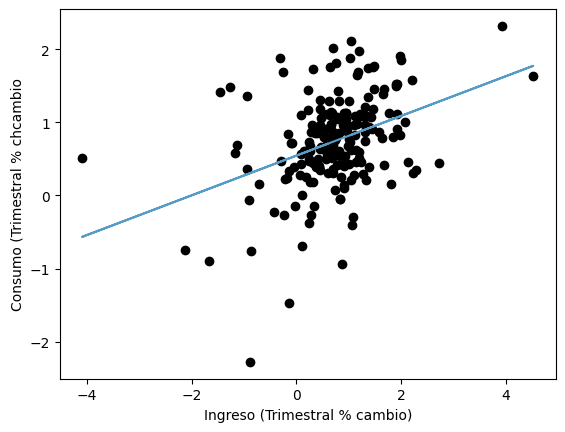

In [18]:
mf = MLForecast(models=LinearRegression(), freq="QS-OCT")
mf.fit(us_change[["ds", "y", "unique_id", "Income"]],
    fitted=True, static_features=[])

fig, ax = plt.subplots()
ax.scatter(us_change["Income"], us_change["y"], color="k")
ax.plot(us_change["Income"],
    mf.forecast_fitted_values()["LinearRegression"])
ax.set(
    xlabel="Ingreso (Trimestral % cambio)",
    ylabel="Consumo (Trimestral % chcambio")
plt.show()

In [22]:
print_regression_summary_from_model(mf.models_["LinearRegression"])

Residuals:
       Min        1Q    Median        3Q       Max
 -2.582358 -0.277767  0.018621  0.323295  1.422291

Coefficients:
             Estimate  Std. Error   t value      Pr(>|t|)     
(Intercept)  0.544542    0.054028  10.07881  0.000000e+00  ***
Income       0.271833    0.046729   5.81728  2.402170e-08  ***
---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.591 on 196 degrees of freedom 
Multiple R-squared: 0.147,    Adjusted R-squared: 0.143 
F-statistic: 33.8 on 1 and 196 DF, p-value: 2.4e-08


c:\Users\fsalcedo\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
